In [1]:
import json
import os
import pickle
from molecule_featurizer import MoleculeFeaturizer

In [2]:
from rdkit.ML.Scoring.Scoring import CalcBEDROC, CalcEnrichment, CalcAUC, CalcROC
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, spearmanr

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [5]:
t = pd.read_csv('results/scaffold_split_0_new_pdbbind')

In [6]:
t.head(1)

,Unnamed: 0,all_targets,all_preds,all_losses,mean_loss,all_bioactive_rank,median_bioactive_rank,bioactive_accuracy,n_bioactive,n_generated,generated_accuracy,ccdc_accuracy,n_heavy_atoms,n_rotatable_bonds,ef20_pred,ef20_ccdc
0,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,"[0.0, 0.1860175, 0.67197174, 0.7574954, 0.8428...","[0.7040276, 0.9599061, 1.0500661, 0.7716163, 0...","[0.4956548511981964, 0.5989035367965698, 0.142...",0.076221,[0],0.0,1.0,1.0,52.0,False,True,19.0,3.0,0.0,1.04


In [7]:
data_dir = 'data/'
pdbbind_refined_dir = '../PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

with open(os.path.join(data_dir, 'random_splits', f'test_smiles_random_split_0.txt'), 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]
    
with open(os.path.join(data_dir, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    cel = pickle.load(f)

In [8]:
encoder_path = os.path.join(data_dir, 'molecule_encoders.p')
if os.path.exists(encoder_path) : # Load existing encoder
    with open(encoder_path, 'rb') as f:
        mol_encoders = pickle.load(f)
mol_featurizer = MoleculeFeaturizer(mol_encoders)

In [11]:
active_ratio = 0.1
regression_table = pd.DataFrame(columns=['split', 'average_type', 'rmse_all', 'rmse_gen', 'rmse_bio', 'r2_all', 'r2_gen', 'pearson_all', 'pearson_gen'])
bioactive_accuracy_table = pd.DataFrame(columns=['split', 'top1_acc', 'topn_acc', 'q1', 'med', 'q3'])
ranking_table = pd.DataFrame(columns=['split', 'ranker', 'ef20', 'bedroc'])

for split in ['random', 'scaffold'] :

    for iteration in range(2) :
        
        t = pd.read_csv(f'results/{split}_split_{iteration}_new_pdbbind')
        t = t[(t['n_generated'] == 100) & (t['Unnamed: 0'] != 'Micro')]

        top1_accuracies = []
        bioactive_ranks = []
        all_targets = []
        all_preds = []
        all_generated_targets = []
        all_generated_energies = []
        all_generated_preds = []
        all_generated_activities = []
        all_bioactive_preds = []
        bedrocs_model = []
        bedrocs_ccdc = []
        bedrocs_random = []
        bedrocs_energy = []
        ef_model = []
        ef_ccdc = []
        ef_random = []
        ef_energy = []
        auc_model = []
        auc_ccdc = []
        auc_random = []
        auc_energy = []
        n_rotatable_bonds = []
        relative_ranks_model = []
        relative_ranks_ccdc = []
        relative_ranks_random = []
        r2s_all = []
        r2s_gen = []
        pearsons_all = []
        pearsons_gen = []
        spearmans_all = []
        spearmans_gen = []
        rmses_all = []
        rmses_gen = []
        rmses_bio = []
        for mol_i in tqdm(range(len(t) - 1)) :

            smiles = t.iloc[mol_i, 0]
            try : 
                ce = cel.get_conf_ensemble(smiles)
                rdkit_mol = ce.mol
                data_list = mol_featurizer.featurize_mol(rdkit_mol)
                energies = [data.energy for data in data_list]
                energies = np.array(energies)

                targets = json.loads(t.iloc[mol_i, 1])
                targets = np.array(targets)
                generated = targets != 0
                generated_targets = targets[generated]
                generated_energies = energies[generated]

                preds = json.loads(t.iloc[mol_i, 2])
                preds = np.array(preds)

                all_targets.extend(targets)
                all_preds.extend(preds)

                r2s_all.append(r2_score(targets, preds))
                pearsons_all.append(pearsonr(targets, preds)[0])
                spearmans_all.append(spearmanr(targets, preds)[0])
                rmses_all.append(mean_squared_error(targets, preds, squared=False))

                is_bioactive = targets == 0
                pred_ranks = preds.argsort().argsort()
                bioactive_pred_ranks = pred_ranks[is_bioactive]
                bioactive_ranks.extend(bioactive_pred_ranks.tolist())

                top1_accuracies.append(0 in bioactive_pred_ranks)

                generated_preds = preds[generated]
                all_generated_targets.extend(generated_targets)
                all_generated_energies.extend(generated_energies)
                all_generated_preds.extend(generated_preds)

                r2s_gen.append(r2_score(generated_targets, generated_preds))
                pearsons_gen.append(pearsonr(generated_targets, generated_preds)[0])
                spearmans_gen.append(spearmanr(generated_targets, generated_preds)[0])
                rmses_gen.append(mean_squared_error(generated_targets, generated_preds, squared=False))

                bioactive_preds = preds[~generated]
                all_bioactive_preds.extend(bioactive_preds)
                rmses_bio.append(np.mean(bioactive_preds))

                actives_i = np.argsort(generated_targets)[:int(len(generated_targets) * active_ratio)]
                activity = [True if i in actives_i else False for i in range(len(generated_preds))]
                all_generated_activities.extend(activity)
                preds_array = np.array(list(zip(generated_preds, activity)))

                relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
                ranks_ccdc = np.array(range(len(generated_preds)))
                relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
                np.random.shuffle(generated_preds)
                relative_ranks_random.extend(generated_preds.argsort().argsort() / len(generated_preds))

                # Prediction ranking
                sorting = np.argsort(preds_array[:, 0])
                sorted_preds_array = preds_array[sorting]

                ef_model.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
                bedrocs_model.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
                auc_model.append(CalcAUC(sorted_preds_array, col=1))

                # Energy ranking
                preds_array = np.array(list(zip(generated_energies, activity)))
                sorting = np.argsort(preds_array[:, 0])
                sorted_preds_array = preds_array[sorting]

                ef_energy.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
                bedrocs_energy.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
                auc_energy.append(CalcAUC(sorted_preds_array, col=1))

                # CCDC ranking
                ef_ccdc.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
                bedrocs_ccdc.append(CalcBEDROC(preds_array, col=1, alpha=20))
                auc_ccdc.append(CalcAUC(preds_array, col=1))

                # Random ranking
                np.random.shuffle(preds_array)
                ef_random.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
                bedrocs_random.append(CalcBEDROC(preds_array, col=1, alpha=20))
                auc_random.append(CalcAUC(preds_array, col=1))

                n_rotatable_bonds.append(int(t.iloc[mol_i, 13]))

                model_roc = CalcROC(sorted_preds_array, col=1)
                ccdc_roc = CalcROC(preds_array, col=1)
                
            except :
                print(smiles)

        q1, med, q3 = np.quantile(bioactive_ranks, [0.25, 0.5, 0.75])

        new_row = pd.Series({'split' : split,
                              'top1_acc' : np.mean(top1_accuracies),
                              'topn_acc' : np.mean(t['bioactive_accuracy']),
                              'q1' : q1,
                              'med' : med,
                              'q3' : q3})
        bioactive_accuracy_table = bioactive_accuracy_table.append(new_row, ignore_index=True)

        new_row = pd.Series({'split' : split,
                              'ranker' : 'Model',
                              'ef20' : np.mean(ef_model),
                              'bedroc' : np.mean(bedrocs_model)})
        ranking_table = ranking_table.append(new_row, ignore_index=True)
        
        new_row = pd.Series({'split' : split,
                              'ranker' : 'Energy',
                              'ef20' : np.mean(ef_energy),
                              'bedroc' : np.mean(bedrocs_energy)})
        ranking_table = ranking_table.append(new_row, ignore_index=True)

        new_row = pd.Series({'split' : split,
                              'ranker' : 'Random',
                              'ef20' : np.mean(ef_random),
                              'bedroc' : np.mean(bedrocs_random)})
        ranking_table = ranking_table.append(new_row, ignore_index=True)

        new_row = pd.Series({'split' : split,
                              'ranker' : 'CCDC',
                              'ef20' : np.mean(ef_ccdc),
                              'bedroc' : np.mean(bedrocs_ccdc)})
        ranking_table = ranking_table.append(new_row, ignore_index=True)
        
        new_row = pd.Series({'split' : split,
                             'average_type' : 'macro',
                              'rmse_all' : np.mean(rmses_all),
                              'rmse_gen' : np.mean(rmses_gen),
                             'rmse_bio' : np.mean(rmses_bio),
                              'r2_all' : np.mean(r2s_all),
                              'r2_gen' : np.mean(r2s_gen),
                                'pearson_all' : np.mean(pearsons_all),
                            'pearson_gen' : np.mean(pearsons_gen),
                            'spearman_all' : np.mean(spearmans_all),
                            'spearman_gen' : np.mean(spearmans_gen)})
        regression_table = regression_table.append(new_row, ignore_index=True)
        
        new_row = pd.Series({'split' : split,
                             'average_type' : 'micro',
                              'rmse_all' : mean_squared_error(all_targets, all_preds, squared=False),
                              'rmse_gen' : mean_squared_error(all_generated_targets, all_generated_preds, squared=False),
                              'rmse_bio' : np.mean(all_bioactive_preds),
                              'r2_all' : r2_score(all_targets, all_preds),
                              'r2_gen' : r2_score(all_generated_targets, all_generated_preds),
                            'pearson_all' : pearsonr(all_targets, all_preds)[0],
                            'pearson_gen' : pearsonr(all_generated_targets, all_generated_preds)[0],
                            'spearman_all' : spearmanr(all_targets, all_preds)[0],
                            'spearman_gen' : spearmanr(all_generated_targets, all_generated_preds)[0]})
        regression_table = regression_table.append(new_row, ignore_index=True)

  1%|▍                                          | 7/715 [00:01<02:01,  5.82it/s]

CCCCCCCCB([OH2+])[OH2+]


  7%|███                                       | 53/715 [00:11<01:39,  6.67it/s]

O=S(=O)(NCB(O)O)c1ccc(-c2nn[nH]n2)cc1C(F)(F)F


  8%|███▏                                      | 55/715 [00:11<01:41,  6.50it/s]RDKit ERROR: [15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
[15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
[15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
[15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
[15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
[15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
[15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [15:36:07] UFFTYPER: Unrecognized charge state for atom: 13
[15:36:07] UFFTYPER: Unrecognized charge state fo

CC1=CC2=[N+]3C1=CC1=[N+]4C(=CC5=[N+]6C(=CC7=[N+](C(=C2)C(C)=C7)[Mg@@-2]346)C(C)=C5CCC(=O)[O-])C(CCC(=O)[O-])=C1C


 23%|█████████▌                               | 167/715 [00:34<01:29,  6.16it/s]

CS(=O)(=O)c1cc(NS(=O)(=O)c2cc(Br)ccc2O)cc(S(F)(F)(F)(F)F)c1


 30%|████████████▎                            | 215/715 [00:44<01:44,  4.76it/s]

C=CC[Se]c1ccc(S(N)(=O)=O)cc1


 37%|██████████████▉                          | 261/715 [00:54<01:47,  4.21it/s]

CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@H]1CO[C@H]2OCC[C@@H]12)S(=O)(=O)c1ccc(B(O)O)cc1


 48%|███████████████████▋                     | 344/715 [01:12<01:12,  5.13it/s]

[NH3+][C@@](CCC[CH2]~B(O)(O)O)(C(=O)[O-])C(F)F


 49%|███████████████████▉                     | 347/715 [01:13<00:53,  6.86it/s]RDKit ERROR: [15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
[15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
[15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
[15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
[15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
[15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
[15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
[15:37:09] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [15:37:09] UFFTYPER: Un

O=S(=O)(NCB(O)O)c1ccc(-c2nnn[nH]2)cc1


 53%|█████████████████████▌                   | 376/715 [01:18<01:03,  5.36it/s]

CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@@H]1[C@@H]2CO[C@@H]3OC[C@H]1C[C@@H]32)S(=O)(=O)c1ccc(B([OH2+])[OH2+])cc1


 54%|██████████████████████▏                  | 388/715 [01:20<00:46,  7.02it/s]

O=S(=O)(Nc1cccc(B(O)O)c1)c1cc(S(=O)(=O)c2ccccc2)cs1


 56%|██████████████████████▊                  | 398/715 [01:22<00:44,  7.06it/s]

NC(=[NH2+])c1ccc([C@@H]2Cc3ccccc3B([OH2+])O2)cc1OCc1cccnc1


 60%|████████████████████████▍                | 427/715 [01:28<00:45,  6.36it/s]

CC#CC[Se]c1ccc(S(N)(=O)=O)cc1


 63%|█████████████████████████▋               | 447/715 [01:33<01:06,  4.06it/s]RDKit ERROR: [15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
[15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
[15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
[15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
[15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
[15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
[15:37:28] UFFTYPER: Unrecognized charge state for atom: 11
[15:37:28] UFFTYPER: Unrecognized charge state fo

CC(=O)N[C@@H](Cc1cccc2ccccc12)B(O)O


 81%|█████████████████████████████████▏       | 579/715 [02:00<00:32,  4.24it/s]RDKit ERROR: [15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
[15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
[15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
[15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
[15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
[15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
[15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [15:37:56] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [15:37:56] UFFTYPER: Unrecognized charge state fo

O=C(Cc1cccs1)N[C@H](B(O)O)c1cccc(C(=O)[O-])c1


  4%|█▌                                        | 28/750 [00:05<02:16,  5.28it/s]RDKit ERROR: [15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
[15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
RDKit ERROR: [15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
[15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
RDKit ERROR: [15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
RDKit ERROR: [15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
[15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
[15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
RDKit ERROR: [15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
RDKit ERROR: [15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
[15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
RDKit ERROR: [15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
RDKit ERROR: [15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
[15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
[15:38:31] UFFTYPER: Unrecognized atom type: N_ (17)
[15:38:31] UFFTYPER: 

[NH3+][C@@H](CCCC[B-2](=O)(O)O)C(=O)[O-]


  8%|███▎                                      | 59/750 [00:12<01:41,  6.79it/s]

NC(=[NH2+])NCCC[C@H](NC(=O)[C@H](Cc1ccc(C[NH3+])cc1)NC(=O)c1ccccc1)B1OCC(O)CO1


  9%|███▋                                      | 66/750 [00:13<02:05,  5.43it/s]

[NH3+][C@@H](CCCC[B-](O)(O)O)C(=O)[O-]


 10%|████▎                                     | 76/750 [00:15<02:29,  4.51it/s]RDKit ERROR: [15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
[15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
RDKit ERROR: [15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
[15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
RDKit ERROR: [15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
[15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
RDKit ERROR: [15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
[15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
RDKit ERROR: [15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
RDKit ERROR: [15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
RDKit ERROR: [15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
RDKit ERROR: [15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
[15:38:42] UFFTYPER: Unrecognized charge state for atom: 16
RDKit ERROR: [15:38:42] UFFTYPER: Un

O=C(Cc1ccccc1)N[C@@H](Cc1cccc(C(=O)[O-])c1)B(O)O


 22%|█████████▏                               | 167/750 [00:35<01:43,  5.62it/s]

[NH3+]Cc1ccc(Oc2ccc3c(c2)B([OH2+])OC3)c(F)c1


 24%|██████████                               | 183/750 [00:38<02:03,  4.61it/s]RDKit ERROR: [15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
[15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
RDKit ERROR: [15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
[15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
RDKit ERROR: [15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
[15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
RDKit ERROR: [15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
RDKit ERROR: [15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
RDKit ERROR: [15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
RDKit ERROR: [15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
[15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
[15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
[15:39:04] UFFTYPER: Unrecognized charge state for atom: 26
RDKit ERROR: [15:39:04] UFFTYPER: Unrecognized ch

CNC(=O)c1c(-c2ccc(F)cc2)oc2cc(N(Cc3cc(F)c4c(c3)COB4[OH2+])S(C)(=O)=O)c(C3C=C3)cc12


 38%|███████████████▍                         | 282/750 [00:59<01:48,  4.30it/s]RDKit ERROR: [15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
[15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
RDKit ERROR: [15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
RDKit ERROR: [15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
[15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
[15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
RDKit ERROR: [15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
[15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
RDKit ERROR: [15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
RDKit ERROR: [15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
[15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
RDKit ERROR: [15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
[15:39:25] UFFTYPER: Unrecognized charge state for atom: 21
[15:39:25] UFFTYPER: Unrecognized charge state fo

[NH3+][C@@]1(C(=O)[O-])C[NH2+]C[C@@H]1CCC[B-]([OH2+])([OH2+])[OH2+]


 51%|████████████████████▊                    | 381/750 [01:19<00:49,  7.48it/s]

C[As+](C)(C)CCO[C@@H](c1ccccc1[N+](=O)[O-])C(F)(F)F


 52%|█████████████████████▏                   | 387/750 [01:20<00:58,  6.20it/s]

O=C1N=C(N2CC[NH+](Cc3ccc(B(O)O)cc3)CC2)S/C1=C\c1ccc(Cl)c(Cl)c1


 55%|██████████████████████▍                  | 410/750 [01:24<01:08,  4.99it/s]

O=C(Cc1cccs1)N[C@@H](Cn1cc(-c2cccc(C(=O)[O-])c2)nn1)B(O)O


 62%|█████████████████████████▎               | 464/750 [01:35<00:45,  6.30it/s]

[NH3+][C@@](CCCC[B-](O)([OH2+])[OH2+])(C(=O)[O-])C1CC[NH+](Cc2ccc(Cl)cc2)CC1


 63%|█████████████████████████▉               | 474/750 [01:38<00:46,  5.97it/s]

C[C@H](CS)C(=O)N[C@H](Cc1coc2ccccc12)B(O)[OH2+]


 72%|█████████████████████████████▍           | 538/750 [01:51<00:35,  5.96it/s]RDKit ERROR: [15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
[15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
[15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
[15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
[15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
[15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
[15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
[15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:40:17] UFFTYPER: Unrecognized atom type: N_ (1)
[15:40:17] UFFTYPER: Unrecognized at

C[C]1O[Fe+7]2345O[C](CCC(=O)NCCCCCN(O2)[C](CCC(=O)NCCCCCN1O3)O4)N(CCCCC[NH3+])O5


  4%|█▊                                        | 32/739 [00:06<01:57,  6.04it/s]

CC12C3(C)C4(C)C5(C)C1(C)[Ir+9]23451([ClH+])[n+]2ccc(O)cc2C(=O)[N@@H+]1CC(=O)Nc1ccc(S(N)(=O)=O)cc1


 37%|███████████████▏                         | 273/739 [00:57<01:32,  5.04it/s]

C=Cc1c(C)c2n3c1[CH]c1c(C)c(C=C)c4n1[FeH2+7]31n3c(c(C)c(C)c3[CH]c3c(CCC(=O)[O-])c(C)c(n31)[CH]4)[CH]2


 48%|███████████████████▋                     | 354/739 [01:14<01:25,  4.50it/s]

O=C([O-])C[C@@H]1CC[C@H](NC(=O)Cc2cccs2)B(O)O1


 55%|██████████████████████▍                  | 404/739 [01:24<00:49,  6.79it/s]

[B+2]c1ccc([C@H](O)CCc2ccc(O)c(C(=O)[O-])c2)cc1


 62%|█████████████████████████▎               | 457/739 [01:36<00:40,  7.05it/s]

C[C@H](CS)C(=O)N[C@H](Cc1coc2ccccc12)B(O)[OH2+]


 65%|██████████████████████████▋              | 481/739 [01:40<00:39,  6.61it/s]

[OH2+][B-]1([OH2+])OCc2ccc(NC(=S)NCc3ccccc3)cc21


 73%|█████████████████████████████▋           | 536/739 [01:52<00:51,  3.91it/s]RDKit ERROR: [15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
[15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
[15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
[15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
[15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
[15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
[15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
[15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
RDKit ERROR: [15:42:52] UFFTYPER: Unrecognized atom type: N_ (1)
[15:42:52] UFFTYPER: Unrecognized at

Cc1ccc([B+]O)cc1OCc1ccccc1


  4%|█▍                                        | 25/713 [00:05<02:37,  4.37it/s]

NS(=O)(=O)c1ccc(CNC(=O)C23[C@@H]4[C@@H]5[C@@H]6[C@H]2[Re+9]5463(C#[O+])(C#[O+])C#[O+])cc1


  7%|███                                       | 53/713 [00:11<02:33,  4.29it/s]

C[C@@H]1[NH2+][C@@H](CC[NH2+]CC2=C3C4=C5[C@H]2[Fe+10]3452678C3=C2C6C7=C38)[C@H](O)[C@@H]1O


 14%|█████▋                                    | 97/713 [00:20<02:17,  4.47it/s]RDKit ERROR: [15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
[15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
[15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
[15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
[15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
[15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
[15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
[15:43:57] UFFTYPER: Unrecognized charge state for atom: 1
RDK

CC1=CC2=[N+]3C1=CC1=[N+]4C(=CC5=[N+]6C(=CC7=[N+](C(=C2)C(C)=C7)[Mg@@-2]346)C(C)=C5CCC(=O)[O-])C(CCC(=O)[O-])=C1C


 20%|████████▏                                | 142/713 [00:30<01:26,  6.63it/s]

[NH3+][C@@](CCCC[B-](O)([OH2+])[OH2+])(C(=O)[O-])[C@@H]1C[C@@H]2CC[C@H](C1)[N@@H+]2Cc1ccc(Cl)c(Cl)c1


 21%|████████▍                                | 147/713 [00:30<01:06,  8.48it/s]

C[C@@H](NC(=O)c1ccccc1Cc1ccccc1)B(O)O


 38%|███████████████▍                         | 268/713 [00:55<01:38,  4.54it/s]

Nc1ncc(C[C@H](C[SeH])C(=O)[O-])cc1Cl


 43%|█████████████████▍                       | 304/713 [01:03<01:07,  6.04it/s]

C[C@@H](NC(=O)c1c(F)cccc1-c1ccccc1)B(O)O


 44%|██████████████████▏                      | 316/713 [01:05<00:58,  6.79it/s]

O=C(Cc1cccs1)N[C@@H](Cn1cc(C(=O)[O-])nn1)B([OH2+])[OH2+]


 50%|████████████████████▎                    | 354/713 [01:12<00:58,  6.17it/s]

O=C1N=C(N2CC[NH+](Cc3ccc(B(O)O)cc3)CC2)S/C1=C\c1ccc(Cl)c(Cl)c1


 52%|█████████████████████▎                   | 371/713 [01:15<00:52,  6.53it/s]

[B+2]c1ccc([C@H](O)CCc2ccc(O)c(C(=O)[O-])c2)cc1


 55%|██████████████████████▎                  | 389/713 [01:19<01:09,  4.68it/s]

O=C(Cc1cccs1)N[C@@H](Cn1cc(C(=O)[O-])nn1)B(O)O


 61%|█████████████████████████▏               | 437/713 [01:30<01:06,  4.15it/s]RDKit ERROR: [15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
[15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
[15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
[15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
[15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
[15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:45:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [15:45:07] UFFTYPER: Unrecognized ch

OB(O)c1ccccc1OCc1cccc(Cl)c1


 96%|███████████████████████████████████████▍ | 686/713 [02:23<00:07,  3.83it/s]RDKit ERROR: [15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
[15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
RDKit ERROR: [15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
RDKit ERROR: [15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
RDKit ERROR: [15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
RDKit ERROR: [15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
RDKit ERROR: [15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
RDKit ERROR: [15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
[15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
[15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
[15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
[15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
[15:46:00] UFFTYPER: Unrecognized charge state for atom: 12
RDKit ERROR: [15:46:00] UFFTYPER: Unrecognized ch

NC(=[NH2+])c1cccc(C[C@@H](NC(=O)N[C@H]2[C@@H]3C[C@H]4C[C@@H](C3)C[C@@H]2C4)C(=O)NCCc2ccccc2)c1


100%|█████████████████████████████████████████| 713/713 [02:28<00:00,  4.80it/s]


In [12]:
len(energies)

101

In [13]:
len(generated)

101

In [14]:
regression_table

,split,average_type,rmse_all,rmse_gen,rmse_bio,r2_all,r2_gen,pearson_all,pearson_gen,spearman_all,spearman_gen
0,random,macro,0.636311,0.622127,1.262221,-0.593670,-0.853659,0.363326,0.334227,0.329440,0.319809
1,random,micro,0.693405,0.680344,1.188885,0.405266,0.399181,0.670336,0.671225,0.643594,0.642461
2,random,macro,0.626477,0.612568,1.220759,-0.603811,-0.977571,0.368519,0.339176,0.327742,0.316422
3,random,micro,0.693764,0.682038,1.196219,0.393689,0.384289,0.664138,0.666223,0.647092,0.646333
4,scaffold,macro,0.624478,0.606068,1.425490,-0.625561,-1.047179,0.305246,0.281194,0.267918,0.258746
5,scaffold,micro,0.669677,0.652831,1.406980,0.433115,0.434880,0.679523,0.686987,0.646644,0.649458
6,scaffold,macro,0.637576,0.619350,1.410499,-0.692720,-1.055737,0.336886,0.314078,0.302250,0.292464
7,scaffold,micro,0.688171,0.671807,1.381641,0.408934,0.407166,0.677593,0.684888,0.657443,0.659799


Text(0.5, 1.0, 'RMSE Loss')

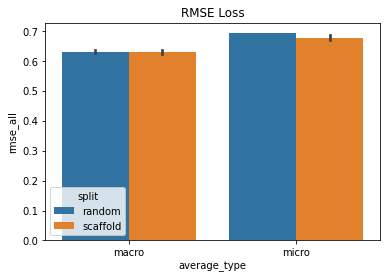

In [32]:
sns.barplot(x='average_type', y='rmse_all', hue='split', data=regression_table)
plt.title('RMSE Loss')

Text(0.5, 1.0, 'R2')

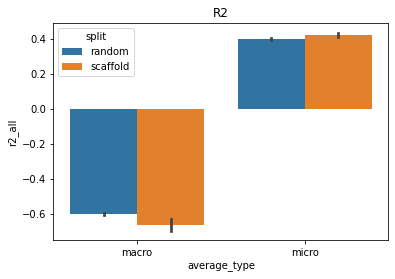

In [33]:
sns.barplot(x='average_type', y='r2_all', hue='split', data=regression_table)
plt.title('R2')

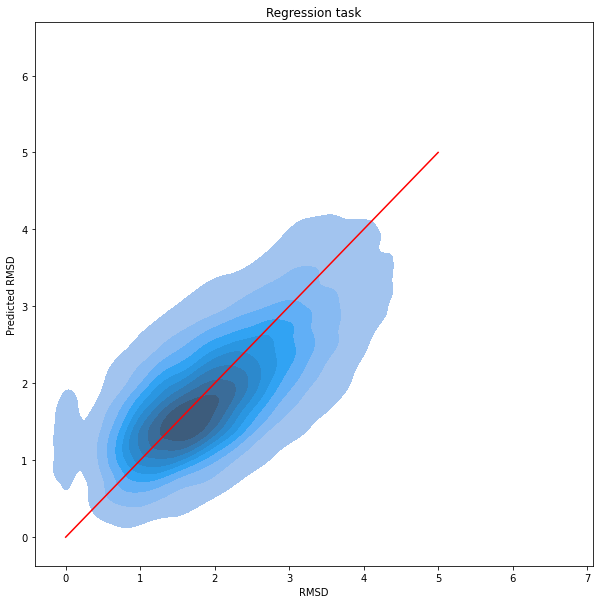

In [27]:
plt.figure(figsize=(10,10))
sns.kdeplot(x=all_targets, y=all_preds, fill=True)
#plt.scatter(flatten_targets, flatten_preds)
plt.title(f'Regression task')
plt.xlabel('RMSD')
plt.ylabel('Predicted RMSD')
plt.plot([0, 5], [0, 5], c='r')
plt.show()

<AxesSubplot:ylabel='Count'>

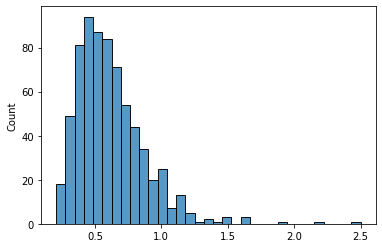

In [15]:
sns.histplot(rmses_gen)

<AxesSubplot:ylabel='Count'>

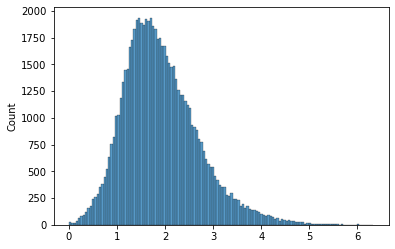

In [16]:
sns.histplot(all_generated_preds)

<AxesSubplot:ylabel='Count'>

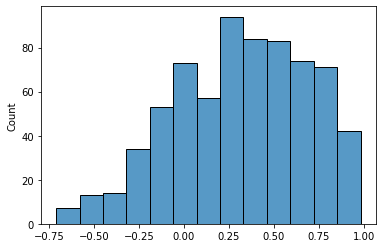

In [17]:
sns.histplot(pearsons_gen)

<AxesSubplot:ylabel='Count'>

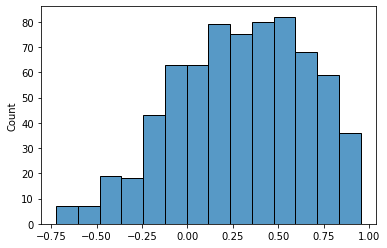

In [18]:
sns.histplot(spearmans_gen)

In [19]:
np.mean(all_generated_preds)

1.9164501807234569

In [20]:
np.std(all_generated_preds)

0.7798915691074757

<AxesSubplot:ylabel='Count'>

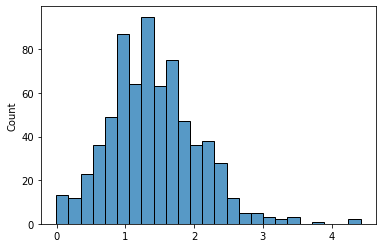

In [21]:
sns.histplot(rmses_bio)

In [22]:
bioactive_accuracy_table

,split,top1_acc,topn_acc,q1,med,q3
0,random,0.339031,0.327095,0.0,6.0,30.00
1,random,0.343284,0.330704,0.0,6.0,29.00
2,scaffold,0.240437,0.231261,1.0,13.0,40.75
3,scaffold,0.254649,0.241281,1.0,11.0,36.00


Text(0.5, 1.0, 'Top1 accuracy')

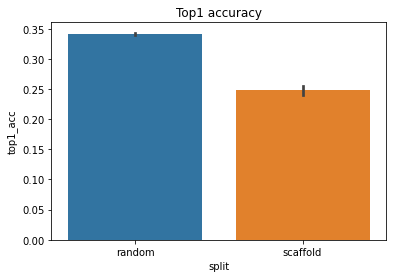

In [36]:
sns.barplot(x='split', y='top1_acc', data=bioactive_accuracy_table)
plt.title('Top1 accuracy')

Text(0.5, 1.0, 'Median')

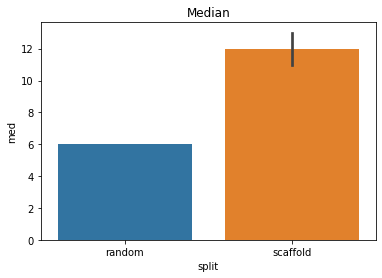

In [41]:
sns.barplot(x='split', y='med', data=bioactive_accuracy_table)
plt.title('Median rank')

Text(0.5, 1.0, 'Distribution of ranks of bioactive conformations')

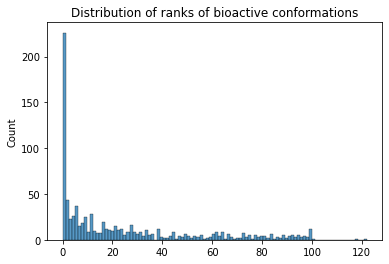

In [39]:
sns.histplot(bioactive_ranks, bins=100)
plt.title('Distribution of ranks of bioactive conformations')

In [23]:
ranking_table

,split,ranker,ef20,bedroc
0,random,Model,2.003561,0.283594
1,random,Energy,1.262821,0.165152
2,random,Random,1.012821,0.116950
3,random,CCDC,1.186610,0.142081
4,random,Model,1.988467,0.279421
5,random,Energy,1.187924,0.152548
6,random,Random,1.012890,0.111572
7,random,CCDC,1.128223,0.136560
8,scaffold,Model,1.792350,0.238745
9,scaffold,Energy,1.219945,0.158495


Text(0.5, 1.0, 'EF20%')

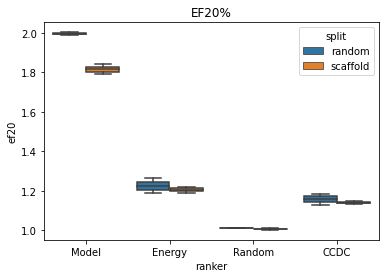

In [42]:
sns.boxplot(data=ranking_table, x='ranker', y='ef20', hue='split')
plt.title('EF20%')

Text(0.5, 1.0, 'BEDROC20')

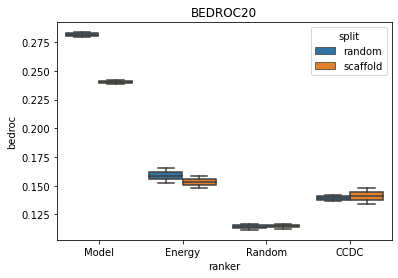

In [43]:
sns.boxplot(data=ranking_table, x='ranker', y='bedroc', hue='split')
plt.title('BEDROC20')

In [ ]:



bioactive_accuracy_table = pd.DataFrame(columns=['split', 'top1_acc', 'topn_acc', 'q1', 'med', 'q3'])
ranking_table = pd.DataFrame(columns=['split', 'ranker', 'ef20', 'bedrocs'])

In [ ]:
iters_mean_top1_accuracies

In [ ]:
iters_mean_topn_accuracies

In [ ]:
iters_mean_ef20s_ccdc

In [ ]:
iters_mean_ef20s_model

In [ ]:
iters_mean_ef20s_random

In [ ]:
iters_mean_bedrocs_ccdc

In [ ]:
iters_mean_bedrocs_model

In [ ]:
iters_mean_bedrocs_random

In [ ]:
active_ratio = 0.1
iters_q1s = []
iters_medians = []
iters_q3s = []
iters_mean_top1_accuracies = []
iters_mean_topn_accuracies = []
iters_mean_ef20s_ccdc = []
iters_mean_ef20s_model = []
iters_mean_ef20s_random = []
iters_mean_bedrocs_ccdc = []
iters_mean_bedrocs_model = []
iters_mean_bedrocs_random = []

for iteration in range(2) :
    t = pd.read_csv(f'results/random_split_{iteration}_new_pdbbind')
    t = t[(t['n_generated'] == 100) & (t['Unnamed: 0'] != 'Micro')]
    
    top1_accuracies = []
    bioactive_ranks = []
    all_targets = []
    all_preds = []
    all_activities = []
    bedrocs_model = []
    bedrocs_ccdc = []
    bedrocs_random = []
    ef_model = []
    ef_ccdc = []
    ef_random = []
    auc_model = []
    auc_ccdc = []
    auc_random = []
    n_rotatable_bonds = []
    relative_ranks_model = []
    relative_ranks_ccdc = []
    relative_ranks_random = []
    for mol_i in tqdm(range(len(t) - 1)) :

        targets = json.loads(t.iloc[mol_i, 1])
        targets = np.array(targets)
        generated = targets != 0
        generated_targets = targets[generated]
        preds = json.loads(t.iloc[mol_i, 2])
        preds = np.array(preds)

        is_bioactive = targets == 0
        pred_ranks = preds.argsort().argsort()
        bioactive_pred_ranks = pred_ranks[is_bioactive]
        bioactive_ranks.extend(bioactive_pred_ranks.tolist())

        top1_accuracies.append(0 in bioactive_pred_ranks)

        generated_preds = preds[generated]
        all_targets.extend(generated_targets)
        all_preds.extend(generated_preds)

        actives_i = np.argsort(generated_targets)[:int(len(generated_targets) * active_ratio)]
        activity = [True if i in actives_i else False for i in range(len(generated_preds))]
        all_activities.extend(activity)
        preds_array = np.array(list(zip(generated_preds, activity)))
        
        relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
        ranks_ccdc = np.array(range(len(generated_preds)))
        relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
        np.random.shuffle(generated_preds)
        relative_ranks_random.extend(generated_preds.argsort().argsort() / len(generated_preds))

        sorting = np.argsort(preds_array[:, 0])
        sorted_preds_array = preds_array[sorting]
        
        ef_model.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
        bedrocs_model.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
        auc_model.append(CalcAUC(sorted_preds_array, col=1))

        ef_ccdc.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_ccdc.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_ccdc.append(CalcAUC(preds_array, col=1))
        
        np.random.shuffle(preds_array)
        ef_random.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_random.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_random.append(CalcAUC(preds_array, col=1))
        
        n_rotatable_bonds.append(int(t.iloc[mol_i, 13]))
        
        model_roc = CalcROC(sorted_preds_array, col=1)
        ccdc_roc = CalcROC(preds_array, col=1)
        
    q1, med, q3 = np.quantile(bioactive_ranks, [0.25, 0.5, 0.75])
    iters_q1s.append(q1)
    iters_medians.append(med)
    iters_q3s.append(q3)
    
    iters_mean_top1_accuracies.append(np.mean(top1_accuracies))
    iters_mean_topn_accuracies.append(np.mean(t['bioactive_accuracy']))
    iters_mean_ef20s_ccdc.append(np.mean(ef_ccdc))
    iters_mean_ef20s_model.append(np.mean(ef_model))
    iters_mean_ef20s_random.append(np.mean(ef_random))
    iters_mean_bedrocs_ccdc.append(np.mean(bedrocs_ccdc))
    iters_mean_bedrocs_model.append(np.mean(bedrocs_model))
    iters_mean_bedrocs_random.append(np.mean(bedrocs_random))

In [ ]:
iters_mean_top1_accuracies

In [ ]:
iters_mean_topn_accuracies

In [ ]:
iters_mean_ef20s_ccdc

In [ ]:
iters_mean_ef20s_model

In [ ]:
iters_mean_ef20s_random

In [ ]:
iters_mean_bedrocs_ccdc

In [ ]:
iters_mean_bedrocs_model

In [ ]:
iters_mean_bedrocs_random

In [ ]:



for mol_i in t.index :
    
    targets = json.loads(t.loc[mol_i, 'all_targets'])
    targets = np.array(targets)
    generated = targets != 0
    generated_targets = targets[generated]
    if len(generated_targets) : 
        preds = json.loads(t.loc[mol_i, 'all_preds'])
        preds = np.array(preds)
        generated_preds = preds[generated]
        all_targets.extend(generated_targets)
        all_preds.extend(generated_preds)

        actives_i = np.argsort(generated_targets)[:int(len(generated_targets) * active_ratio)]
        activity = [True if i in actives_i else False for i in range(len(generated_preds))]
        all_activities.extend(activity)
        preds_array = np.array(list(zip(generated_preds, activity)))
        
        relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
        ranks_ccdc = np.array(range(len(generated_preds)))
        relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
        np.random.shuffle(generated_preds)
        relative_ranks_random.extend(generated_preds.argsort().argsort() / len(generated_preds))

        sorting = np.argsort(preds_array[:, 0])
        sorted_preds_array = preds_array[sorting]
        
        ef_model.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
        bedrocs_model.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
        auc_model.append(CalcAUC(sorted_preds_array, col=1))

        ef_ccdc.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_ccdc.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_ccdc.append(CalcAUC(preds_array, col=1))
        
        np.random.shuffle(preds_array)
        ef_random.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_random.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_random.append(CalcAUC(preds_array, col=1))
        
        
        n_rotatable_bonds.append(int(t.loc[mol_i, 'n_rotatable_bonds']))
        
        model_roc = CalcROC(sorted_preds_array, col=1)
        ccdc_roc = CalcROC(preds_array, col=1)

The issue is that we can't rank conformations with CCDC from different molecules.
In practice, we would rank conformations for the same molecule.

In [ ]:
top1_accuracies = []
bioactive_ranks = []
n_non_gen = 0

for mol_i in tqdm(range(len(t) - 1)) :
    
    targets = json.loads(t.iloc[mol_i, 1])
    targets = np.array(targets)
    generated = targets != 0
    generated_targets = targets[generated]
    if len(generated_targets) : 
        preds = json.loads(t.iloc[mol_i, 2])
        preds = np.array(preds)
        
        is_bioactive = targets == 0
        pred_ranks = preds.argsort().argsort()
        bioactive_pred_ranks = pred_ranks[is_bioactive]
        bioactive_ranks.extend(bioactive_pred_ranks.tolist())

        top1_accuracies.append(0 in bioactive_pred_ranks)
    else :
        n_non_gen += 1
        
    q1, med, q3 = np.quantile(bioactive_ranks, [0.25, 0.5, 0.75])

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(bioactive_ranks, bins=100)

In [ ]:
q1, med, q3 = np.quantile(bioactive_ranks, [0.25, 0.5, 0.75])

In [ ]:
np.mean(top1_accuracies)

In [ ]:
np.mean(t['bioactive_accuracy'])

In [ ]:
active_ratio = 0.1

all_targets = []
all_preds = []
all_activities = []
bedrocs_model = []
bedrocs_ccdc = []
bedrocs_random = []
ef_model = []
ef_ccdc = []
ef_random = []
auc_model = []
auc_ccdc = []
auc_random = []
n_rotatable_bonds = []
relative_ranks_model = []
relative_ranks_ccdc = []
relative_ranks_random = []
for mol_i in t.index :
    
    targets = json.loads(t.loc[mol_i, 'all_targets'])
    targets = np.array(targets)
    generated = targets != 0
    generated_targets = targets[generated]
    if len(generated_targets) : 
        preds = json.loads(t.loc[mol_i, 'all_preds'])
        preds = np.array(preds)
        generated_preds = preds[generated]
        all_targets.extend(generated_targets)
        all_preds.extend(generated_preds)

        actives_i = np.argsort(generated_targets)[:int(len(generated_targets) * active_ratio)]
        activity = [True if i in actives_i else False for i in range(len(generated_preds))]
        all_activities.extend(activity)
        preds_array = np.array(list(zip(generated_preds, activity)))
        
        relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
        ranks_ccdc = np.array(range(len(generated_preds)))
        relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
        np.random.shuffle(generated_preds)
        relative_ranks_random.extend(generated_preds.argsort().argsort() / len(generated_preds))

        sorting = np.argsort(preds_array[:, 0])
        sorted_preds_array = preds_array[sorting]
        
        ef_model.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
        bedrocs_model.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
        auc_model.append(CalcAUC(sorted_preds_array, col=1))

        ef_ccdc.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_ccdc.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_ccdc.append(CalcAUC(preds_array, col=1))
        
        np.random.shuffle(preds_array)
        ef_random.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_random.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_random.append(CalcAUC(preds_array, col=1))
        
        
        n_rotatable_bonds.append(int(t.loc[mol_i, 'n_rotatable_bonds']))
        
        model_roc = CalcROC(sorted_preds_array, col=1)
        ccdc_roc = CalcROC(preds_array, col=1)
        
#         plt.plot(model_roc.FPR, model_roc.TPR, label='model')
#         plt.plot(ccdc_roc.FPR, ccdc_roc.TPR, label='ccdc')
#         plt.legend()
#         plt.show()

In [ ]:
thresholds = [n for n in np.arange(0, 1, 0.01)]
retrieved_ccdc = []
retrieved_model = []
retrieved_random = []
relative_ranks_ccdc = np.array(relative_ranks_ccdc)
relative_ranks_model = np.array(relative_ranks_model)
relative_ranks_random = np.array(relative_ranks_random)
all_activities = np.array(all_activities)
n_actives = sum(all_activities)
for threshold in tqdm(thresholds) :
    ccdc_below_threshold = relative_ranks_ccdc < threshold
    retrieved_ccdc.append((all_activities * ccdc_below_threshold).sum() / n_actives)
    model_below_threshold = relative_ranks_model < threshold
    retrieved_model.append((all_activities * model_below_threshold).sum() / n_actives)
    random_below_threshold = relative_ranks_random < threshold
    retrieved_random.append((all_activities * random_below_threshold).sum() / n_actives)

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(thresholds, retrieved_model, label='model')
plt.plot(thresholds, retrieved_ccdc, label='ccdc')
plt.plot(thresholds, retrieved_random, label='random')
plt.legend()

In [ ]:
sns.histplot(all_targets, bins=50)

In [ ]:
preds_array = np.array(list(zip(all_preds, all_activities)))
sorting = np.argsort(preds_array[:, 0])
sorted_preds_array = preds_array[sorting]

In [ ]:
sns.histplot(x=preds_array[:,0], hue=preds_array[:,1], bins=40)

In [ ]:
CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])

In [ ]:
CalcEnrichment(preds_array, col=1, fractions=[0.2])

In [ ]:
CalcBEDROC(sorted_preds_array, col=1, alpha=20)

In [ ]:
CalcBEDROC(preds_array, col=1, alpha=20)

In [ ]:
from scipy.stats import describe

In [ ]:
describe(bedrocs_model)

In [ ]:
describe(bedrocs_ccdc)

In [ ]:
describe(bedrocs_random)

In [ ]:
np.median(bedrocs_model)

In [ ]:
np.median(bedrocs_ccdc)

In [ ]:
np.median(bedrocs_random)

In [ ]:
describe(ef_model)

In [ ]:
describe(ef_ccdc)

In [ ]:
describe(ef_random)

In [ ]:
describe(auc_model)

In [ ]:
describe(auc_ccdc)

In [ ]:
describe(auc_random)

In [ ]:
sns.boxplot(x=n_rotatable_bonds, y=bedrocs_model)

In [ ]:
sns.boxplot(x=n_rotatable_bonds, y=ef_model)

In [ ]:
sns.boxplot(x=n_rotatable_bonds, y=ef_ccdc)

In [ ]:
sns.boxplot(x=n_rotatable_bonds, y=bedrocs_ccdc)

In [ ]:
actives_i = np.argsort(targets)[:int(len(targets) / 10)]
activity = [True if i in actives_i else False for i in range(len(preds)) ]

In [ ]:
preds_array = np.array(list(zip(preds, activity)))
sorting = np.argsort(preds_array[:, 0])
sorted_preds_array = preds_array[sorting]

In [ ]:
CalcBEDROC(sorted_preds_array, col=1, alpha=20)

In [ ]:
CalcBEDROC(preds_array, col=1, alpha=20)

In [ ]:
t_nomicro = t.dropna(subset=['n_heavy_atoms']).copy()
t_nomicro['n_heavy_atoms'] = t_nomicro['n_heavy_atoms'].astype(int)
t_nomicro['n_rotatable_bonds'] = t_nomicro['n_rotatable_bonds'].astype(int)

In [ ]:
#plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_heavy_atoms', y='n_rotatable_bonds')

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='mean_loss')

In [ ]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='mean_loss')

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='n_bioactive')

In [ ]:
sns.histplot(data=t_nomicro, x='n_generated')

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='n_generated')

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_generated', y='mean_loss')

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_bioactive', y='bioactive_accuracy')

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_bioactive', y='median_bioactive_rank')

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='median_bioactive_rank')

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='median_bioactive_rank')

In [ ]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='ef20_ccdc')

In [ ]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='ef20_pred')

In [ ]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=t_nomicro, x='ef20_ccdc', y='ef20_pred')

In [ ]:
t_100gen = t_nomicro[t_nomicro['n_generated'] == 100]
plt.figure(figsize=(7,7))
sns.kdeplot(data=t_100gen, x='ef20_ccdc', y='ef20_pred')

In [ ]:
sns.scatterplot(data=t_nomicro, x='n_generated', y='ef20_ccdc')

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(data=t_nomicro, x='n_generated', y='ef20_pred')

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(data=t_nomicro, x='n_generated', y='ef20_ccdc')

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='median_bioactive_rank')

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='bioactive_accuracy')